In [1]:
#Import data and libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  LSTM
from tensorflow.keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
# Have a look at our data

In [5]:
data = pd.read_excel('../raw_data/data_daily_filter.xlsx', engine='openpyxl').drop(columns='Unnamed: 0')

In [6]:
data.head()

,date_issue,total_amount_claims
0,2018-09-01,168
1,2018-09-02,332
2,2018-09-03,7185
3,2018-09-04,4100
4,2018-09-05,3497


In [7]:
# The value to predict is the column total_amount_claims. Let's define "y" and have a look at its trend

In [8]:
# length of data frame

In [9]:
len_data = len(data)
len_data

917

In [10]:
# Select feature to predict

In [11]:
y = data['total_amount_claims']
y.head()

0     168
1     332
2    7185
3    4100
4    3497
Name: total_amount_claims, dtype: int64

In [12]:
# Convert feature to array

In [13]:
y = np.array(y)

In [14]:
y.shape

(917,)

In [15]:
y = y.reshape(-1,1)

In [16]:
y.shape

(917, 1)

In [17]:
# Plot y

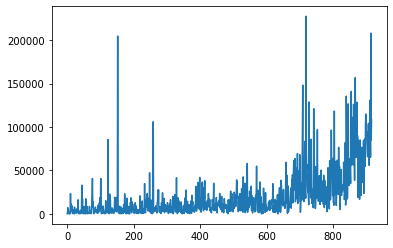

In [18]:
plt.plot(y);

In [19]:
# We will use shifted versions of the column Y as independent variables, that is to say use 3 delays of Y
# as inputs to predict the output of our data.

In [20]:
X1 = y[0:len_data-6,:]
X2 = y[1:len_data-5,:]
X3 = y[2:len_data-4,:]
X4 = y[3:len_data-3,:]
X5 = y[4:len_data-2,:]
X6 = y[5:len_data-1,:]
y = y[6:len_data,:]

In [21]:
X1.size

911

In [22]:
X2.size

911

In [23]:
X3.size

911

In [24]:
y.size

911

In [25]:
X = np.concatenate([X1,X2,X3,X4,X5,X6],axis=1)

In [26]:
X

array([[   168,    332,   7185,   4100,   3497,    326],
       [   332,   7185,   4100,   3497,    326,   1706],
       [  7185,   4100,   3497,    326,   1706,    260],
       ...,
       [ 78381,  55910,  93081, 130873, 102035,  65304],
       [ 55910,  93081, 130873, 102035,  65304, 208034],
       [ 93081, 130873, 102035,  65304, 208034,  85163]])

In [27]:
print(f'X shape is {X.shape}')
print(f'Y shape is {y.shape}')

X shape is (911, 6)
Y shape is (911, 1)


In [28]:
# we standardize our data both our variable x and our variable y between 0 and 1

In [29]:
# LSTM needs 3 dimensional input so we have to reshape the X input into 3 dimensions.

In [30]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler.fit(y)
y = scaler.transform(y)

X= np.reshape(X, (X.shape[0],1,X.shape[1]))

In [31]:
X.shape

(911, 1, 6)

In [32]:
# Define training and test sets for our model

In [33]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [34]:
len_ = int(0.8*X.shape[0])
X_train = X[:len_,:,:]
X_test = X[len_:,:,:]
y_train = y[:len_,:]
y_test = y[len_:,:]

In [35]:
print(f'X train size:{X_train.shape}')
print(f'X test size:{X_test.shape}')
print(f'y train size:{y_train.shape}')
print(f'y test size:{y_test.shape}')

X train size:(728, 1, 6)
X test size:(183, 1, 6)
y train size:(728, 1)
y test size:(183, 1)


In [36]:
# model building

In [37]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [38]:
model = models.Sequential()
model.add(layers.LSTM(64, activation='tanh', return_sequences=False))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

In [39]:
# We use mean absolute error to assess our model and then we fit our model to the training set and launch the prediction

In [40]:
model.compile(optimizer='RMSprop',
            loss='MeanSquaredError',
            metrics=['mse', 'mae', 'mape'])


In [41]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=50, restore_best_weights=True)
model.fit(X_train, y_train,
        validation_split=0.2,
        epochs=200,
        verbose=1,
        batch_size=32,
        callbacks=[es]
        )

Epoch 1/200
19/19 [==============================] - 4s 67ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0345 - mape: 48515.4557 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.0809 - val_mape: 130.1164
Epoch 2/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0291 - mape: 31140.9615 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.0756 - val_mape: 148.2779
Epoch 3/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0334 - mape: 33797.1225 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.0725 - val_mape: 156.1359
Epoch 4/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0302 - mape: 23764.6748 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0787 - val_mape: 124.7535
Epoch 5/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0324 - mape: 49450.6848 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.0765 - val

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18176     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Model Mean Absolute Error {model_mae[1]:.4f}')

Model Mean Absolute Error 0.0537


In [44]:
Predict = model.predict(X_test)

In [45]:
# Let’s now have a visualization comparing the prediction versus the test set to see how our model performed

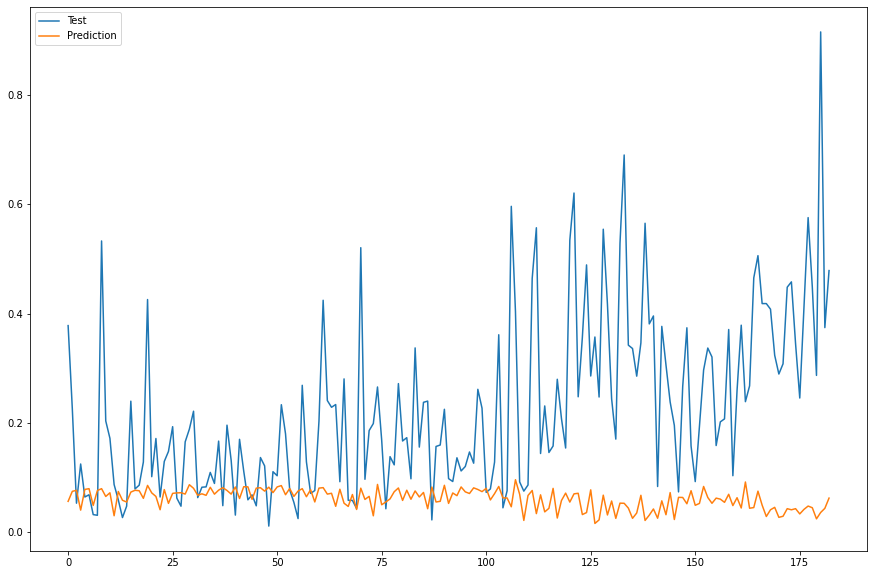

In [46]:
plt.figure(figsize=(15,10))
plt.plot(y_test,label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [47]:
# Let’s now add time indexes and scale back to the original scale

In [48]:
y_train = scaler.inverse_transform(y_train)

In [49]:
y_train = pd.DataFrame(y_train)
y_train.index = pd.to_datetime(data.iloc[6:734,0])
y_train

,0
date_issue,
2018-09-07,1706.0
2018-09-08,260.0
2018-09-09,31.0
2018-09-10,204.0
2018-09-11,23453.0
...,...
2020-09-02,26561.0
2020-09-03,51312.0
2020-09-04,35574.0


In [50]:
y_test = scaler.inverse_transform(y_test)

In [51]:
y_test = pd.DataFrame(y_test)
y_test.index = pd.to_datetime(data.iloc[734:,0])
y_test

,0
date_issue,
2020-09-07,85999.0
2020-09-08,51568.0
2020-09-09,12203.0
2020-09-10,28497.0
2020-09-11,14784.0
...,...
2021-03-04,102035.0
2021-03-05,65304.0
2021-03-06,208034.0


In [52]:
Predict = scaler.inverse_transform(Predict)

In [53]:
Predict = pd.DataFrame(Predict)
Predict.index=pd.to_datetime(data.iloc[734:,0])
Predict

,0
date_issue,
2020-09-07,12972.968750
2020-09-08,17128.419922
2020-09-09,17562.751953
2020-09-10,9333.362305
2020-09-11,17926.738281
...,...
2021-03-04,10323.596680
2021-03-05,5707.909668
2021-03-06,8353.389648


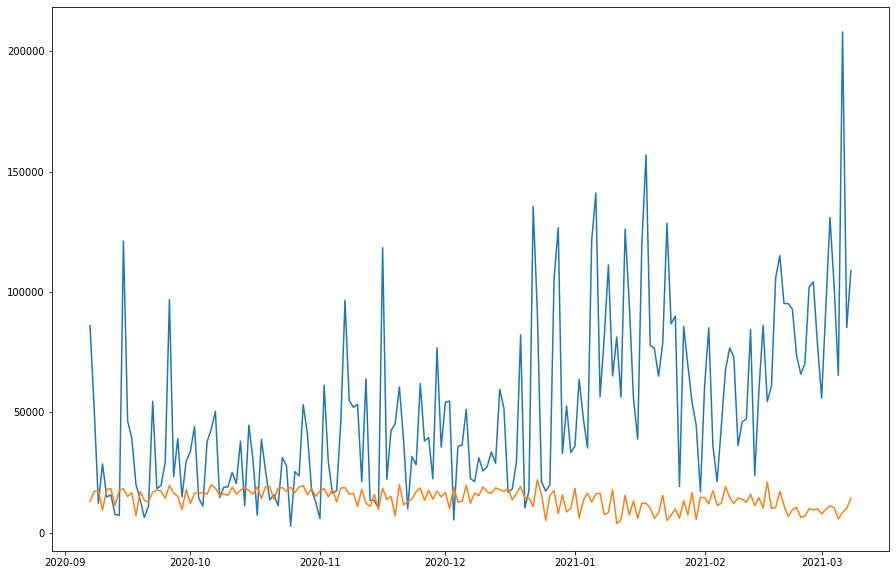

In [54]:
plt.figure(figsize=(15,10))
plt.plot(y_test)
plt.plot(Predict)
plt.show()

In [55]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 3915218688.0000 - mse: 3915218688.0000 - mae: 51230.1094 - mape: 99.9998


[3915218688.0, 3915218688.0, 51230.109375, 99.99976348876953]